<a href="https://colab.research.google.com/github/E-wave112/ml_proj1/blob/master/aws_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('dark_background')
import string
import boto3
import tensorflow
tensorflow.config.run_functions_eagerly(True)
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model
from keras.models import Sequential,Input
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow.keras.layers import concatenate

if sys.version_info[0] < 3: 
    from StringIO import StringIO # Python 2.x
else:
    from io import StringIO # Python 3.x

##set your credentials and secret
AWS_ID =os.environ['AWS_ID']
AWS_SECRET_KEY=os.environ['AWS_SECRET_KEY']

##use the boto3 aws client sdk to integrate python and aws s3
client = boto3.client('s3', aws_access_key_id=AWS_ID,
        aws_secret_access_key=AWS_SECRET_KEY)

##get the object name and the object key(the actual .csv file)
bucket_name = 'edjangobucket'
object_key = 'fake_news.csv'

csv_object = client.get_object(Bucket=bucket_name, Key=object_key)
csv_body = csv_object['Body']
csv_string = csv_body.read().decode('utf-8')

df = pd.read_csv(StringIO(csv_string))
print(df.head())
##drop the date column
df.drop(['date'],axis=1,inplace=True)
##data cleansing and preprocessing
data_process = df[['title','text','subject']]

# Basic function to clean the text, remove urls and special characters from each text
def clean_text(text):
    ##remove numbers
    text_nums=''.join([word for word in text if not word.isdigit()])
    ##remove urls
    text_urls= re.sub(r'https?://\S+|www\.\S+',"", text_nums)
    ##remove nicks
    text_nicks= re.sub(r"\@\S+", "",text_urls)
    # Removing spaces and converting text into lowercase
    return text_nicks.strip().lower()

stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
# remove stop words
def remove_stopwords(text):
    words = [w for w in text if w not in stop_words]
    return "".join(words)

# perform further cleaning to remove quotation marks and other apostrophes
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}


def clean_further_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

data_process_1 = data_process.applymap(clean_text)
data_process_2 = data_process_1.applymap(clean_further_text)
# data_process_3 = data_process_2.applymap(clean_further_text)

print(data_process_2.head(10))
# use the tokenizer object to further preprocess the text
max_words = 8192
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
    lower=True
)

MAX_SEQUENCE_LENGTH = 150
# first text input model
data_process = df[['title','text','subject']]
title = data_process_2['title']
tokenizer.fit_on_texts(title)
title = tokenizer.texts_to_sequences(title)
title = pad_sequences(title,maxlen=MAX_SEQUENCE_LENGTH,padding='post')
print(tokenizer)
title_vocab = len(tokenizer.word_index) + 1
print(title_vocab)

# second text input model
text = data_process_2['text']
tokenizer.fit_on_texts(text)
text = tokenizer.texts_to_sequences(text)
text = pad_sequences(text,maxlen=MAX_SEQUENCE_LENGTH,padding='post')
text_vocab = len(tokenizer.word_index) + 1
print(text_vocab)

# third input model
subject = data_process_2['subject']
tokenizer.fit_on_texts(subject)
subject = tokenizer.texts_to_sequences(subject)
subject = pad_sequences(subject,maxlen=MAX_SEQUENCE_LENGTH,padding='post')
subject_vocab = len(tokenizer.word_index) + 1
print(subject_vocab)


Y = df['Type']
Y = np.array(Y)

Y =to_categorical(Y)
print(Y)

title_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints

text_input = keras.Input(
    shape=(None,), name="text"
)  # Variable-length sequence of ints

subject_input = keras.Input(
    shape=(None,), name="subject"
)  # Variable-length sequence of ints


# Embed each word in the title into a 64-dimensional vector
title_features = Embedding(title_vocab, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
text_features = Embedding(text_vocab, 64)(text_input)
# Embed each word in the title into a 64-dimensional vector
subject_features = Embedding(subject_vocab, 64)(subject_input)

# Reduce sequence of embedded words in the title_features into a single 128-dimensional vector
title_features_lstm = LSTM(128,activation="sigmoid",dropout = 0.3, recurrent_dropout = 0.3)(title_features)
# Reduce sequence of embedded words in the text_features into a single 128-dimensional vector
text_features_lstm = LSTM(128,activation="sigmoid",dropout = 0.3, recurrent_dropout = 0.3)(text_features)
# Reduce sequence of embedded words in the subject_features into a single 128-dimensional vector
subject_features_lstm = LSTM(128,activation="sigmoid",dropout = 0.3, recurrent_dropout = 0.3)(subject_features)

X = concatenate([title_features_lstm,text_features_lstm,subject_features_lstm])
# X_pred = X.numpy()

# Stick a logistic regression for priority prediction on top of the features
X_pred = Dense(128,activation = 'relu')(X)
# X_pred = SpatialDropout1D(0.3)(X_pred)
# X_pred = Dropout(0.3)(X_pred)
X_pred = Dense(32,activation = 'relu')(X_pred)
# X_pred = SpatialDropout1D(0.3)(X_pred)
# X_pred = Dropout(0.3)(X_pred)
X_pred = Dense(2,activation = 'sigmoid')(X_pred)


batch_size = 64
epochs = 4
model = keras.Model(
    inputs=[title_input, text_input, subject_input],
    outputs=X_pred
)

plot_model(model, "/content/drive/MyDrive/tnlp/news_nlp_model.png", show_shapes=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['AUC']
)


model.summary()

                                               title  ... Type
0  Woman accusing Trump of misconduct subpoenas p...  ...    1
1  Trump's Commerce pick Wilbur Ross is no strang...  ...    1
2   Trump’s New Pathetic Anti-Hillary Ad Frames B...  ...    0
3  Trump warns 'rogue regime' North Korea of grav...  ...    1
4  LIKE A BAD PENNY: OBAMAS CRASH Music Awards to...  ...    0

[5 rows x 5 columns]
                                               title  ...       subject
0  woman accusing trump of misconduct subpoenas p...  ...  politicsnews
1  trump is commerce pick wilbur ross is no stran...  ...  politicsnews
2  trump’s new pathetic anti-hillary ad frames bi...  ...          news
3  trump warns 'rogue regime' north korea of grav...  ...  politicsnews
4  like a bad penny: obamas crash music awards to...  ...      politics
5  factbox: latest obamacare repeal bill would bl...  ...  politicsnews
6  beware the united nations push for “global gov...  ...     left-news
7  two trump tweets debu

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/4
562/562 [==============================] - 2721s 5s/step - loss: 0.4927 - auc: 0.7841 - val_loss: 0.0802 - val_auc: 0.9937
Epoch 2/4
562/562 [==============================] - 2735s 5s/step - loss: 0.0820 - auc: 0.9941 - val_loss: 0.0426 - val_auc: 0.9978
Epoch 3/4
562/562 [==============================] - 2746s 5s/step - loss: 0.0414 - auc: 0.9982 - val_loss: 0.0332 - val_auc: 0.9982
Epoch 4/4
562/562 [==============================] - 2707s 5s/step - loss: 0.0237 - auc: 0.9991 - val_loss: 0.0317 - val_auc: 0.9985
Saved model to disk


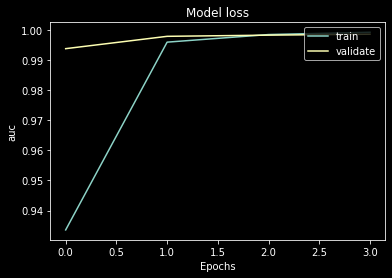

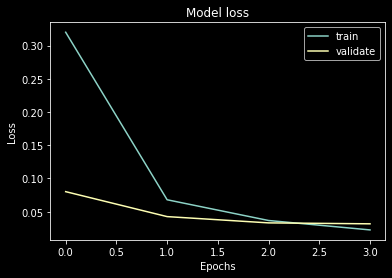

In [ ]:
history = model.fit(
     {"title":title,"text":text,"subject":subject},
    Y,
    validation_split = 0.20,
    epochs = epochs,
    batch_size = batch_size, callbacks=EarlyStopping(monitor="val_loss",
                                              min_delta=0.002,
                                              patience=5)
)

model.save("/content/drive/MyDrive/tnlp/nlp_model.h5")
print("Saved model to disk")
##learning curve for model accuracy
plt.title('Model loss')
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.legend(['train','validate'],loc ='upper right')
plt.show()


##learning curve for model loss
plt.title('Model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','validate'],loc ='upper right')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
start = stopwords.words('english')

with open('/content/drive/MyDrive/ustacky/text.txt','w+') as w:
  w.write(f'{start}')

print(len(start))
print(start)
print(len(stop))

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than